<a id = 'title'></a>

# Контекст

Вы аналитик в онлайн-маркетплейсе «Заберу». Это настоящий рай для любителей бесполезных сувениров — там можно приобрести товары ручной работы от небольших производителей. «Заберу» проводит рекламные акции длительностью 1 день. Руководитель отдела маркетинга хочет узнать, насколько эффективны такие кампании.

# Цели исследования:

---

# [Шаг 1. Прочитаем датасеты и сделаем предподготовку данных](#stage_1)

---

# [Шаг 2. Расчеты показателей](#stage_2)

- [Посчитайте затраты на каждый рекламный источник.](#stage_2_1)

---

- [Посчитайте суммарную выручку, максимальную и минимальную выручку от заказов, сделанных пользователями, которые хотя бы раз перешли на сайт с настольных ПК (тип устройства desktop) из рекламного источника, на который было потрачено больше всего денег. Определить рекламный источник, на который было потрачено больше всего денег, можно как из результатов выполнения задания 1, так и с помощью подзапроса. Сделайте выводы.](#stage_2_2)

---

- [Введём новую метрику эффективности рекламны - дневные затраты на рекламу на пользователя по источнику. Она рассчитывается для каждого отдельного дня и равна объёму денежных средств, которые были израсходованы на то, чтобы пользователь перешёл по рекламе на сайт из данного рекламного источника. Иными словами, метрика для каждого дня равна отношению рекламных затрат по данному источнику к количеству посетителей, перешедших на сайт с данного источника. Рассчитайте для каждого дня введённую метрику. Считайте, что целевое действие было произведено тогда, когда сесия началась. Например, если посетитель провёл на сайте несколько минут с 23:50 14 апреля по 0:20 15 апреля, то его нужно включать в рассчёт за 14 апреля](#stage_2_3)

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---

<a id = 'stage_1'></a>

# Шаг 1. Прочитаем датасеты и сделаем предподготовку данных

[к оглавлению](#title)

In [3]:
visits = pd.read_csv('visits_log.csv')
costs = pd.read_csv('costs.csv')
orders = pd.read_csv('orders_log.csv')

VISITS

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


пустых значений нет

In [5]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [6]:
# сделаем нижний регистр у всех колонок и упростим названия

visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [7]:
# приведем в нормальний тип данных (object --> datetime)

visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [8]:
# Сколько дубликатов ?
visits.duplicated().sum()

0

COSTS

In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


нет пустых значений

In [10]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [11]:
# поменяем название колонки "dt" в "date" для лучшего понимания и поменяем тип данных

costs = costs.rename({'dt': 'date'}, axis = 1)
costs['date'] = pd.to_datetime(costs['date'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   date       2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [12]:
# Сколько дубликатов ?
costs.duplicated().sum()

0

ORDERS

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


нет пустых значений

In [14]:
# названия колонок в нижний регистр и поменяем тип данных у времени

orders.columns = ['buy_ts', 'revenue', 'uid']
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [15]:
# Сколько дубликатов ?
orders.duplicated().sum()

0

---

<a id = 'stage_2'></a>

# Шаг 2. Расчеты показателей

[к оглавлению](#title)

---

<a id = 'stage_2_1'></a>

#### 2.1. Посчитайте затраты на каждый рекламный источник.

[к оглавлению](#title)

In [16]:
costs_per_source = \
costs.groupby('source_id').agg({'costs':'sum'}).reset_index().rename({'costs': 'sum_costs'}, axis = 1)

costs_per_source

,source_id,sum_costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


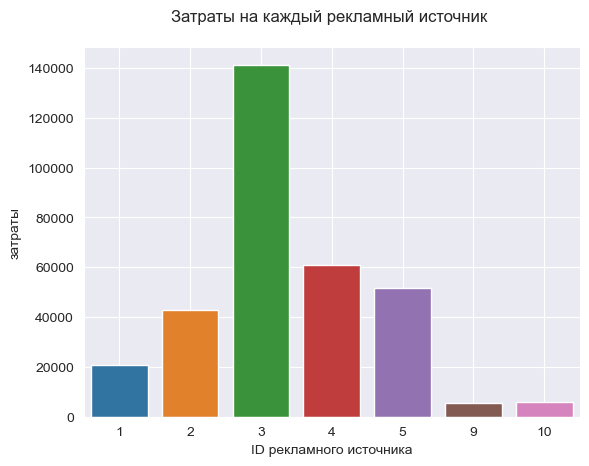

In [17]:
sns.set_style('darkgrid', {'gridcolor':'.6'})

sns.barplot(data = costs_per_source,
            x = 'source_id',
            y = 'sum_costs')
plt.title('Затраты на каждый рекламный источник \n')
plt.xlabel('ID рекламного источника')
plt.ylabel('затраты')
plt.grid(visible='x')
plt.show()

---

<a id = 'stage_2_2'></a>

#### 2.2. Посчитайте суммарную выручку, максимальную и минимальную выручку от заказов, сделанных пользователями, которые хотя бы раз перешли на сайт с настольных ПК (тип устройства desktop) из рекламного источника, на который было потрачено больше всего денег. Определить рекламный источник, на который было потрачено больше всего денег, можно как из результатов выполнения задания 1, так и с помощью подзапроса. Сделайте выводы.

[к оглавлению](#title)

In [18]:
# выделяем из датасета visits только строки 3-го источника (самого затратного (это мы выяснили выше)) и только ПК сессии
visits_source_3_and_desktop = visits[(visits['source_id'] == 3) & (visits['device'] == 'desktop')]
visits_source_3_and_desktop.head()

,device,end_ts,source_id,start_ts,uid
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
13,desktop,2017-11-27 14:43:00,3,2017-11-27 14:42:00,1989613820989570316
27,desktop,2017-10-23 12:58:00,3,2017-10-23 12:49:00,4499746016005494365
37,desktop,2018-03-12 23:25:00,3,2018-03-12 23:13:00,15857957287537270437


In [19]:
orders['date'] = pd.to_datetime(orders['buy_ts'].dt.date)
orders.head()

,buy_ts,revenue,uid,date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [20]:
visits_source_3_and_desktop['date'] = pd.to_datetime(visits_source_3_and_desktop['start_ts'].dt.date)
visits_source_3_and_desktop.head()

C:\Users\oudel\AppData\Local\Temp\ipykernel_17444\240073418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits_source_3_and_desktop['date'] = pd.to_datetime(visits_source_3_and_desktop['start_ts'].dt.date)


,device,end_ts,source_id,start_ts,uid,date
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017-07-19
13,desktop,2017-11-27 14:43:00,3,2017-11-27 14:42:00,1989613820989570316,2017-11-27
27,desktop,2017-10-23 12:58:00,3,2017-10-23 12:49:00,4499746016005494365,2017-10-23
37,desktop,2018-03-12 23:25:00,3,2018-03-12 23:13:00,15857957287537270437,2018-03-12


In [21]:
desktop_source_3 =\
visits_source_3_and_desktop.merge(orders,
                                  on = ['date', 'uid'])

max_revenue_2_2 = desktop_source_3['revenue'].max()
min_revenue_2_2 = desktop_source_3['revenue'].min()
sum_revenue_2_2 = desktop_source_3['revenue'].sum()
print(f'Максимальная выручка от пользователя ПК, пришедшему по 3-му рекламному источнику: {max_revenue_2_2}')
print(f'Минимальная выручка от пользователя ПК, пришедшему по 3-му рекламному источнику: {min_revenue_2_2}')
print(f'Сумарная выручка от пользователей ПК, пришедших по 3-му рекламному источнику: {sum_revenue_2_2}')

Максимальная выручка от пользователя ПК, пришедшему по 3-му рекламному источнику: 550.0
Минимальная выручка от пользователя ПК, пришедшему по 3-му рекламному источнику: 0.0
Сумарная выручка от пользователей ПК, пришедших по 3-му рекламному источнику: 36502.03


Выручка 0 при заказе возможна при акциии бксплатного товара или ошибки системы (выяснить, почему такое возможно)

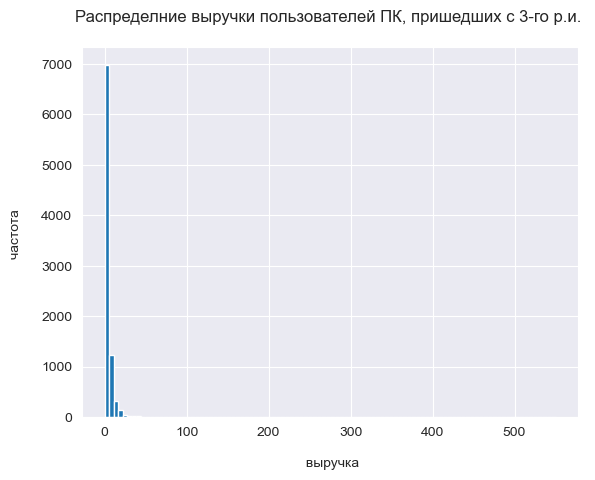

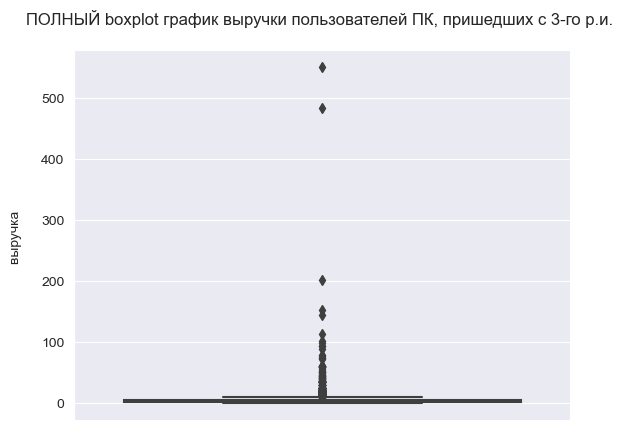

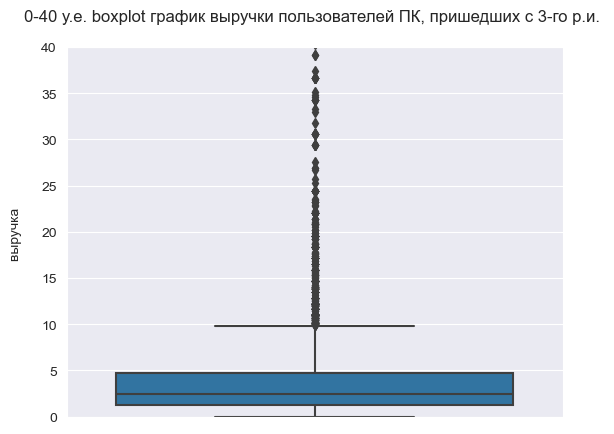

In [22]:
# посмотрим на распределение выручки

desktop_source_3['revenue'].plot(kind = 'hist',
                                 bins = 100)
plt.title('Распределние выручки пользователей ПК, пришедших с 3-го р.и. \n')
plt.xlabel('\n выручка')
plt.ylabel('частота \n')
plt.show()

sns.boxplot(data = desktop_source_3,
            y = 'revenue')
plt.title('ПОЛНЫЙ boxplot график выручки пользователей ПК, пришедших с 3-го р.и. \n')
plt.ylabel('выручка \n')
plt.show()


sns.boxplot(data = desktop_source_3,
            y = 'revenue')
plt.title('0-40 у.е. boxplot график выручки пользователей ПК, пришедших с 3-го р.и. \n')
plt.ylabel('выручка \n')
plt.ylim((0, 40))
plt.show()

Вывод:

- выручка пользователей ПК, пришедших с 3-го р.и. подвежена выбросам
- медианное значение - 2.5 у.е.
- есть выручка 0 у.е. - причины не известны, НАДО СПРОСИТЬ (возможна ошибка системы, а возможно акция)
- 550 у.е. - максимальная выручка с одного заказа - это выброс

---

<a id = 'stage_2_3'></a>

#### 2.3. Введём новую метрику эффективности рекламны - дневные затраты на рекламу на пользователя по источнику. Она рассчитывается для каждого отдельного дня и равна объёму денежных средств, которые были израсходованы на то, чтобы пользователь перешёл по рекламе на сайт из данного рекламного источника. Иными словами, метрика для каждого дня равна отношению рекламных затрат по данному источнику к количеству посетителей, перешедших на сайт с данного источника. Рассчитайте для каждого дня введённую метрику. Считайте, что целевое действие было произведено тогда, когда сесия началась. Например, если посетитель провёл на сайте несколько минут с 23:50 14 апреля по 0:20 15 апреля, то его нужно включать в рассчёт за 14 апреля

[к оглавлению](#title)

In [34]:
# введем колонку дня начала сессии
visits['date'] = pd.to_datetime(visits['start_ts'].dt.date)
visits.head()

,device,end_ts,source_id,start_ts,uid,date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27


In [38]:
# считаем уникальное количество пользователей по дню и источнику (скорее всего имелось это ввиду). Посетители и пользователи --> разный вид подсчетов
count_unique_users =\
visits.groupby(['source_id', 'date']).agg({'uid': 'nunique'}).reset_index()

count_unique_users

,source_id,date,uid
0,1,2017-06-01,61
1,1,2017-06-02,50
2,1,2017-06-03,37
3,1,2017-06-04,44
4,1,2017-06-05,73
...,...,...,...
2577,10,2018-05-27,10
2578,10,2018-05-28,44
2579,10,2018-05-29,31
2580,10,2018-05-30,68


In [41]:
data_2_3 =\
count_unique_users.merge(costs,
                         on = ['source_id', 'date'])

data_2_3.head()

,source_id,date,uid,costs
0,1,2017-06-01,61,75.20
1,1,2017-06-02,50,62.25
2,1,2017-06-03,37,36.53
3,1,2017-06-04,44,55.00
4,1,2017-06-05,73,57.08


In [45]:
data_2_3['costs_per_user_source_per_day'] = (data_2_3['costs'] / data_2_3['uid']).round(2)
data_2_3.head()

,source_id,date,uid,costs,costs_per_user_source_per_day
0,1,2017-06-01,61,75.20,1.23
1,1,2017-06-02,50,62.25,1.25
2,1,2017-06-03,37,36.53,0.99
3,1,2017-06-04,44,55.00,1.25
4,1,2017-06-05,73,57.08,0.78


[Text(0, 0, '2017-06-01 00:00:00'),
 Text(1, 0, '2017-06-02 00:00:00'),
 Text(2, 0, '2017-06-03 00:00:00'),
 Text(3, 0, '2017-06-04 00:00:00'),
 Text(4, 0, '2017-06-05 00:00:00'),
 Text(5, 0, '2017-06-06 00:00:00'),
 Text(6, 0, '2017-06-07 00:00:00'),
 Text(7, 0, '2017-06-08 00:00:00'),
 Text(8, 0, '2017-06-09 00:00:00'),
 Text(9, 0, '2017-06-10 00:00:00'),
 Text(10, 0, '2017-06-11 00:00:00'),
 Text(11, 0, '2017-06-12 00:00:00'),
 Text(12, 0, '2017-06-13 00:00:00'),
 Text(13, 0, '2017-06-14 00:00:00'),
 Text(14, 0, '2017-06-15 00:00:00'),
 Text(15, 0, '2017-06-16 00:00:00'),
 Text(16, 0, '2017-06-17 00:00:00'),
 Text(17, 0, '2017-06-18 00:00:00'),
 Text(18, 0, '2017-06-19 00:00:00'),
 Text(19, 0, '2017-06-20 00:00:00'),
 Text(20, 0, '2017-06-21 00:00:00'),
 Text(21, 0, '2017-06-22 00:00:00'),
 Text(22, 0, '2017-06-23 00:00:00'),
 Text(23, 0, '2017-06-24 00:00:00'),
 Text(24, 0, '2017-06-25 00:00:00'),
 Text(25, 0, '2017-06-26 00:00:00'),
 Text(26, 0, '2017-06-27 00:00:00'),
 Text(27, 0

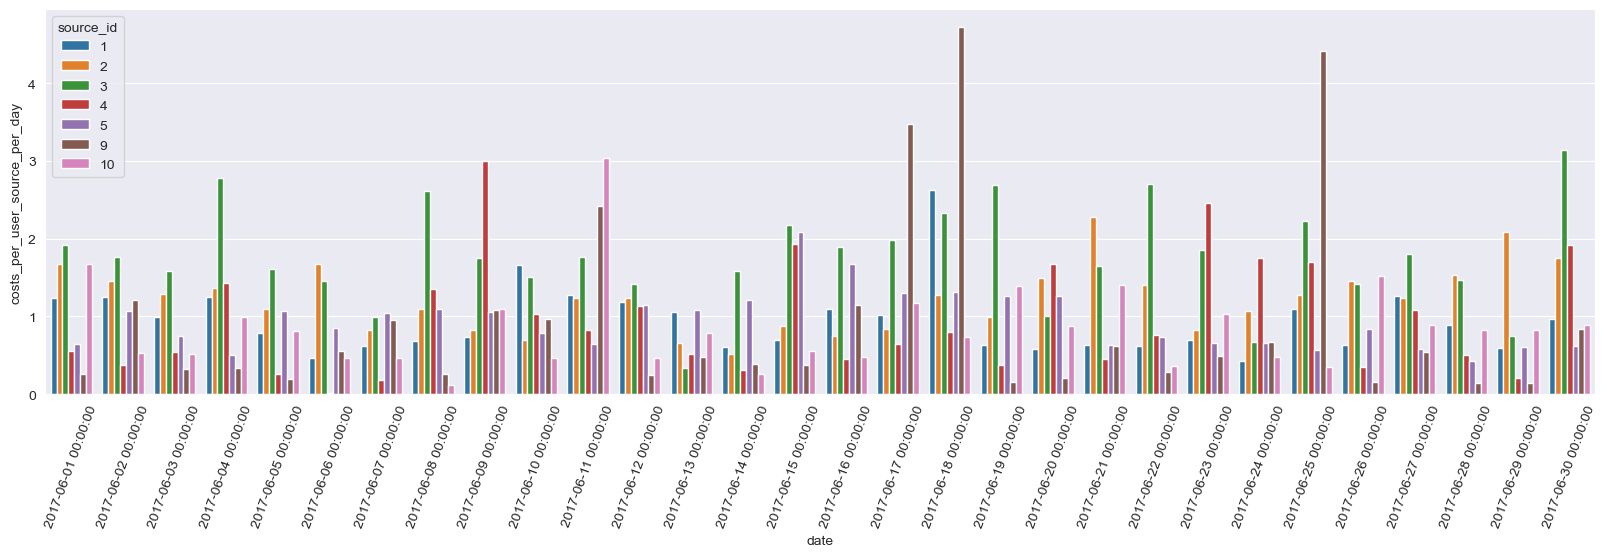

In [79]:
from datetime import datetime

data_for_plot =\
data_2_3[data_2_3['month'] == '2017-06']

plt.figure(figsize=(20,5))
ax =\
sns.barplot(data = data_for_plot,
            x = 'date',
            y = 'costs_per_user_source_per_day',
            hue = 'source_id')
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
